In [2]:
import pandas as pd
import os
import json
import numpy as np
import nltk
from textsimilarity import get_bert_features, get_w2v_features, get_similarity
from textsimilarity.preprocess import get_coref_and_dp
from textsimilarity.build_semantic_graph import build_semantic_graph
from textsimilarity.build_semantic_graph.build_tree import build_tree
from textsimilarity.build_semantic_graph.prune_and_merge_tree import prune
from textsimilarity.build_semantic_graph.rearrange_tree import rearrange
from textsimilarity.build_semantic_graph.build_graph import get_graph
from textsimilarity.build_semantic_graph.merge_graph import merge
from textsimilarity import draw_graph
from nltk.corpus import stopwords
import neuralcoref
import spacy
import xlrd
from sentence_transformers import SentenceTransformer, util
from nltk.corpus import wordnet as wn
nlp = spacy.load('en')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiajinghu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jiajinghu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiajinghu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from sklearn.metrics import ndcg_score

In [3]:
financial_news_raw_dir = '../data/financial_news/raw'

In [7]:
df_dict = {'title':[],
          'text':[]}
subfolders = os.listdir(financial_news_raw_dir)
for folders in subfolders:
    if not folders.startswith('.'):
        files = os.listdir(os.path.join(financial_news_raw_dir, folders))
        for file in files:
            file_path = os.path.join(financial_news_raw_dir, folders, file)
            try:
                with open(file_path) as f:
                    data = json.load(f)
                df_dict['title'].append(data['thread']['title'])
                df_dict['text'].append(data['text'])
            except:
                continue
            

In [8]:
news_df = pd.DataFrame(df_dict)
news_df.to_csv('../data/financial_news/interim/financial_news.csv', index=False, encoding='utf-8')

In [3]:
news_df = pd.read_csv('../data/financial_news/interim/financial_news.csv')

In [11]:
print(news_df.shape)
news_df.head()

(306242, 2)


,title,text
0,BRIEF-AU Optronics to pay cash dividend of T$1...,March 27(Reuters) - AU Optronics Corp :\n* Say...
1,British stats watchdog - stop using RPI inflat...,"March 8, 2018 / 1:35 PM / Updated an hour ago ..."
2,Dropbox shares surge in IPO,"Dropbox shares surge in IPO Saturday, March 24..."
3,Bookkeeper of Auschwitz dies before starting s...,BERLIN (Reuters) - The man known as the “bookk...
4,US stocks set for a negative open as trade war...,Dow closes 336 points higher as trade-war worr...


In [34]:
stock_df = news_df[news_df.text.str.contains('news')]
print(stock_df.shape)
stock_df.head()

(66415, 2)


,title,text
4,US stocks set for a negative open as trade war...,Dow closes 336 points higher as trade-war worr...
6,The Wall Street Journal: Ex-Playboy model who ...,74 COMMENTS A former Playboy playmate who says...
7,James Kinsey joins Avison Young in New York City,Highly regarded industry veteran becomes Princ...
8,Embattled Australian PM Turnbull forced to del...,"March 28, 2018 / 5:07 AM / Updated 34 minutes ..."
10,FedEx Corp. Reports Third Quarter Earnings,"MEMPHIS, Tenn.--(BUSINESS WIRE)-- FedEx Corp. ..."


In [37]:
obama_df = news_df[news_df.text.str.lower().str.contains('obama')]
print(obama_df.shape)
obama_df.to_csv('../data/financial_news/interim/obama.csv', index=False)
obama_df.head()

,title,text
15,"UPDATE 2-Trump meets ""Doom"" maker and other vi...","(Updates with end of meeting, adds comments fr..."
134,EXCLUSIVE-Pimco economist Clarida seen as fron...,"-sources@\nNEW YORK, March 1 (Reuters) - Richa..."
172,"WRAPUP 3-CERAWEEK-At energy summit, climate pi...","(Adds additional details, comments)\nHOUSTON, ..."
206,U.S. miners seek reversal of uranium mining ba...,WASHINGTON (Reuters) - The U.S. mining industr...
267,U.S. Interior chief halts second federal oil l...,"WASHINGTON, March 5 (Reuters) - U.S. Interior ..."


In [11]:
obama_df = pd.read_csv('../data/financial_news/interim/obama.csv')

In [7]:
trump_df= news_df[news_df.text.str.lower().str.contains('trump')]
print(trump_df.shape)
trump_df.to_csv('../data/financial_news/interim/trump.csv', index=False)
trump_df.head()

NameError: name 'news_df' is not defined

In [111]:
violen_trump_df = trump_df[trump_df.text.str.lower().str.contains('violen')]
violen_trump_df.shape

(1109, 2)

In [114]:
media_violen_df = violen_trump_df[violen_trump_df.text.str.lower().str.contains('media')]
media_violen_df.shape

(411, 2)

In [148]:
def get_word2vec_embeddings(doc, with_coref=True):
    if with_coref:
        coref = get_coref_and_dp.get_neural_coreference(doc)
        doc = ' '.join(coref)
    nlp_doc = nlp(doc)
    emb = np.array([nlp_doc[i].vector for i in range(len(doc.split()))])
    return emb

def get_graph_from_sent(sentence):
    dp = get_coref_and_dp.get_spacy_dependency(sentence)
    coref = get_coref_and_dp.get_neural_coreference(sentence)
    w2v = get_word2vec_embeddings(' '.join(coref))
    data = build_semantic_graph.merge_dp_coref([dp], [coref])
    sent = build_tree(data[0])
    sent = {'sequence':sent['words'], 'tree':prune(sent['tree'], sent['words'])}
    sent = {'sequence': sent['sequence'], 'tree': rearrange(sent['tree'], sent['sequence'])}
    return get_graph(sent['tree']), w2v
    
    

In [20]:
verb_pos = ['VBZ', 'VBN', 'VBD', 'VBP', 'VB', 'VBG', 'VERB']
prep_pos = ['PP', 'IN', 'TO']
subj_and_obj = ['nsubj', 'nsubjpass', 'csubj', 'csubjpass'] + ['dobj', 'pobj', 'iobj', 'obj']
conj = ['conj', 'parataxis']
modifier_pos = ['JJ', 'FW', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'ADJ', 'X', 'ADV']
modifiers = ['amod', 'nn', 'mwe', 'advmod', 'quantmod', 'npadvmod', 'advcl', 'poss', 'acl', 'appos',
             'possessive', 'neg', 'auxpass', 'aux', 'det', 'dep', 'predet', 'num','nmod','nummod']



In [21]:
query_sentence = 'Trump, a Republican, has talked about how violence in media affects children'
query_dp = get_coref_and_dp.get_spacy_dependency(query_sentence)
query_coref = get_coref_and_dp.get_neural_coreference(query_sentence)
query_w2v = get_word2vec_embeddings(' '.join(query_coref))
query_data = build_semantic_graph.merge_dp_coref([query_dp], [query_coref])
sent = build_tree(query_data[0])
sent = {'sequence':sent['words'], 'tree':prune(sent['tree'], sent['words'])}
sent = {'sequence': sent['sequence'], 'tree': rearrange(sent['tree'], sent['sequence'])}
query_graph = get_graph(sent['tree'])
query_graph, query_w2v = get_graph_from_sent(query_sentence)

In [118]:
sentences = []
for text in media_violen_df.text.values:
#     sentences.extend([x for x in nltk.sent_tokenize(text) if len(nltk.word_tokenize(x))<30])
    sentences.extend([x.split('\n')[0] for x in nltk.sent_tokenize(text) if (len(nltk.word_tokenize(x))>10 and 
                                                                             'violen' in x) ])
len(sentences)

685

In [119]:
sents_dp = list(map(get_coref_and_dp.get_spacy_dependency, sentences))

In [120]:
sents_coref = list(map(get_coref_and_dp.get_neural_coreference, sentences))

In [121]:
sents_w2v = np.array(list(map(get_word2vec_embeddings, 
                                              list(map(lambda x: ' '.join(x), sents_coref)))))


<ipython-input-121-daae24cd85d3>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sents_w2v = np.array(list(map(get_word2vec_embeddings,


In [122]:
sents_graph = []
sents_data = build_semantic_graph.merge_dp_coref(sents_dp, sents_coref)
for sent in sents_data:
    sent = build_tree(sent)
    sent = {'sequence':sent['words'], 'tree':prune(sent['tree'], sent['words'])}
    sent = {'sequence': sent['sequence'], 'tree': rearrange(sent['tree'], sent['sequence'])}
    graph = get_graph(sent['tree'])
    sents_graph.append(graph)

In [129]:
sim = []
for i in range(len(sentences)):
    sim.append(get_similarity.get_wms(coref_query_sentence, sentences[i], query_w2v, sents_w2v[i]))
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished
15 finished
16 finished
17 finished
18 finished
19 finished
20 finished
21 finished
22 finished
23 finished
24 finished
25 finished
26 finished
27 finished
28 finished
29 finished
30 finished
31 finished
32 finished
33 finished
34 finished
35 finished
36 finished
37 finished
38 finished
39 finished
40 finished
41 finished
42 finished
43 finished
44 finished
45 finished
46 finished
47 finished
48 finished
49 finished
50 finished
51 finished
52 finished
53 finished
54 finished
55 finished
56 finished
57 finished
58 finished
59 finished
60 finished
61 finished
62 finished
63 finished
64 finished
65 finished
66 finished
67 finished
68 finished
69 finished
70 finished
71 finished
72 finished
73 finished
74 finished
75 finished
76 finished
77 finished
78 finished
79 finished
80 finished
81 finished
82 finished
83 finished
84

657 finished
658 finished
659 finished
660 finished
661 finished
662 finished
663 finished
664 finished
665 finished
666 finished
667 finished
668 finished
669 finished
670 finished
671 finished
672 finished
673 finished
674 finished
675 finished
676 finished
677 finished
678 finished
679 finished
680 finished
681 finished
682 finished
683 finished
684 finished


In [154]:
graph_sim = []
for i in range(len(sentences)):
    graph_s = get_similarity.get_graph_similarity(query_graph, sents_graph[i], query_w2v, sents_w2v[i], 0.9)
    if type(graph_s) != np.float64:
        graph_s = graph_s[0]
    graph_sim.append(graph_s)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished
15 finished
16 finished
17 finished
18 finished
19 finished
20 finished
21 finished
22 finished
23 finished
24 finished
25 finished
26 finished
27 finished
28 finished
29 finished
30 finished
31 finished
32 finished
33 finished
34 finished
35 finished
36 finished
37 finished
38 finished
39 finished
40 finished
41 finished
42 finished
43 finished
44 finished
45 finished
46 finished
47 finished
48 finished
49 finished
50 finished
51 finished
52 finished
53 finished
54 finished
55 finished
56 finished
57 finished
58 finished
59 finished
60 finished
61 finished
62 finished
63 finished
64 finished
65 finished
66 finished
67 finished
68 finished
69 finished
70 finished
71 finished
72 finished
73 finished
74 finished
75 finished
76 finished
77 finished
78 finished
79 finished
80 finished
81 finished
82 finished
83 finished
84

670 finished
671 finished
672 finished
673 finished
674 finished
675 finished
676 finished
677 finished
678 finished
679 finished
680 finished
681 finished
682 finished
683 finished
684 finished


In [131]:
sim_df = pd.DataFrame({'sentences':sentences, 'wms':sim, 'graph_sim_0.9':graph_sim}).drop_duplicates()
sim_df

,sentences,wms,graph_sim_0.9
0,"(Updates with end of meeting, adds comments fr...",0.458973,1.222985
1,Trump has said he would consider a wide range ...,1.179924,3.234361
2,"Trump, a Republican, has talked about the need...",1.923584,3.817072
3,The president's free-wheeling deliberations on...,1.236032,2.304948
4,The conversation lasted for almost an hour and...,1.922453,5.775132
...,...,...,...
670,"“In Dallas, gun violence survivors, students a...",1.719625,6.236942
675,WASHINGTON (Reuters) - The White House on Mond...,0.960994,0.277098
679,"Bell talked to immigrants, refugees and advoca...",1.149130,3.837605
680,For a neighborhood that has seen its share of ...,1.316275,3.017513


In [132]:
sim_df[sim_df.sentences.str.contains('Trump, a Republican, has talked about the need to examine how violence in media affects children')]

,sentences,wms,graph_sim_0.9
2,"Trump, a Republican, has talked about the need...",1.923584,3.817072


In [133]:
sim_df.sort_values('wms',ascending=False).to_csv('../data/financial_news/interim/trump_violence_sim1.csv',index=False)

In [220]:
def get_graph_similarity(graph1, graph2, emb1, emb2, threshold):
    # we treat graph1 as the query document
    embedding1 = get_similarity.get_node_embeddings(graph1, emb1)
    embedding2 = get_similarity.get_node_embeddings(graph2, emb2)
    
    w_match = 1
    w_nonmatch = 0.5
    
    graph_sim = []
    node_match = []
    for i2, e2 in enumerate(embedding2):
        node_sim = []
        for e1 in embedding1:
            if (np.all(e1==0))|(np.all(e2==0)):
                node_sim.append(0)
            else:
                node_sim.append(get_similarity.cosine_similarity(e1, e2))
        max_sim_node = np.argmax(node_sim)
        if max(node_sim) >= threshold:
            node_match.append((max_sim_node, i2))
        graph_sim.append(max(node_sim))
        print(f"{graph2['nodes'][i2]['word']} matches {graph1['nodes'][max_sim_node]['word']}")
        
#     print('node match: ', node_match)
    if len(node_match) <= 1:
        return sum(graph_sim)*w_nonmatch/len(graph2), None
    else:
        weights = np.zeros(len(graph_sim)) + w_nonmatch
        for i in range(len(node_match)):
            for j in range(i, len(node_match)):
                n1_g1 = node_match[i][0]
                n1_g2 = node_match[i][1]
                n2_g1 = node_match[j][0]
                n2_g2 = node_match[j][1]
                
                n1_n2_g1 = graph1['edges'][n1_g1][n2_g1]
                n2_n1_g1 = graph1['edges'][n2_g1][n1_g1]

                n1_n2_g2 = graph2['edges'][n1_g2][n2_g2]
                n2_n1_g2 = graph2['edges'][n2_g2][n1_g2]

                if ((n1_n2_g1!='')&(n1_n2_g1 == n1_n2_g2))|((n2_n1_g1!='')&(n2_n1_g1 == n2_n1_g2)):
                    weights[n1_g2] += (w_match-w_nonmatch)
                    weights[n2_g2] += (w_match-w_nonmatch)
#                     print(n1_g2)
#                     print(n2_g2)
                    print('(', graph1['nodes'][n1_g1]['word'], ',', graph1['nodes'][n2_g1]['word'], ') matches ','(',
                         graph2['nodes'][n1_g2]['word'], ',', graph2['nodes'][n2_g2]['word'], ')')
                    
        return np.dot(graph_sim, weights)/len(graph2), weights

### Read in the 30 sentences

In [212]:
sim_30_df.to_csv('../data/financial_news/interim/trump_media_crime_30examples.csv', index=False)


In [7]:
sim_30_df = pd.read_csv('../data/financial_news/interim/trump_media_crime_30examples.csv')
sim_30_df.head()

,sentences,wms,graph_sim_0.9,whole_sent_sim,subject_sim,action_sim,obj_sim,graph_sim_0
0,U.S. President Donald Trump will meet on Thurs...,3.074172,2.077737,1.0,1,1.0,1.0,2.289166
1,"Other attendees included Sen. Marco Rubio , R-...",3.501067,5.166904,0.0,0,0.0,1.0,5.543940
2,a video game violence researcher and someone w...,3.243640,4.745135,0.5,0,1.0,1.0,5.591926
3,He has invited the National Rifle Association ...,3.101859,2.968415,0.0,0,0.0,1.0,3.771345
4,After it was revealed that the two teenagers w...,2.176154,2.987470,0.5,0,0.0,1.0,3.213094


In [163]:
new_graph_sim = []
for i in range(len(sim_30_df.sentences)):
    sent_graph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[i])
    graph_s = get_similarity.get_graph_similarity(query_graph, 
                                                  sent_graph, 
                                                  query_w2v, 
                                                  sent_w2v, 0.9)
    if type(graph_s) != np.float64:
        graph_s = graph_s[0]
    new_graph_sim.append(graph_s)
    print(f'{i} finished')
sim_30_df['new_graph_sim_0.9'] = new_graph_sim

/Users/jiajinghu/projects/pattern-recognition/src/textsimilarity/get_similarity.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node_features.append(embeddings[[node['index']]].mean(axis=0))


0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished
15 finished
16 finished
17 finished
18 finished
19 finished
20 finished
21 finished
22 finished
23 finished
24 finished
25 finished
26 finished
27 finished
28 finished
29 finished
30 finished


In [164]:
sim_30_df.head()

,sentences,wms,graph_sim_0.9,whole_sent_sim,subject_sim,action_sim,obj_sim,graph_sim_0,new_graph_sim_0,new_graph_sim_0.9
0,U.S. President Donald Trump will meet on Thurs...,3.074172,2.077737,1.0,1,1.0,1.0,2.289166,1.778541,1.560307
1,"Other attendees included Sen. Marco Rubio , R-...",3.501067,5.166904,0.0,0,0.0,1.0,5.543940,3.482985,3.105948
2,a video game violence researcher and someone w...,3.243640,4.745135,0.5,0,1.0,1.0,5.591926,4.228472,3.571592
3,He has invited the National Rifle Association ...,3.101859,2.968415,0.0,0,0.0,1.0,3.771345,3.402542,2.307183
4,After it was revealed that the two teenagers w...,2.176154,2.987470,0.5,0,0.0,1.0,3.213094,2.424501,2.197423


In [165]:
wms_pairwise_whole_sent = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))
graph_pairwise_whole_sent = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))

wms_pairwise_subj = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))
graph_pairwise_subj = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))

wms_pairwise_action = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))
graph_pairwise_action = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))

wms_pairwise_obj = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))
graph_pairwise_obj = np.zeros((sim_30_df.shape[0], sim_30_df.shape[0]))

In [170]:
# get concordance for whole_sen_sim
for i1 in range(sim_30_df.shape[0]):
    for i2 in range(i1+1, sim_30_df.shape[0]):
        
        # wms whole sent sim
        if (sim_30_df.whole_sent_sim.iloc[i1] - sim_30_df.whole_sent_sim.iloc[i2])*\
        (sim_30_df.wms.iloc[i1] - sim_30_df.wms.iloc[i2]) > 0:
            wms_pairwise_whole_sent[i1,i2] = 1
        # wms subj sim
        if (sim_30_df.subject_sim.iloc[i1] - sim_30_df.subject_sim.iloc[i2])*\
        (sim_30_df.wms.iloc[i1] - sim_30_df.wms.iloc[i2]) > 0:
            wms_pairwise_subj[i1,i2] = 1
        #wms action sim
        if (sim_30_df.action_sim.iloc[i1] - sim_30_df.action_sim.iloc[i2])*\
        (sim_30_df.wms.iloc[i1] - sim_30_df.wms.iloc[i2]) > 0:
            wms_pairwise_action[i1,i2] = 1
        #wms obj sim
        if (sim_30_df.obj_sim.iloc[i1] - sim_30_df.obj_sim.iloc[i2])*\
        (sim_30_df.wms.iloc[i1] - sim_30_df.wms.iloc[i2]) > 0:
            wms_pairwise_obj[i1,i2] = 1
            
        # graph whole sent sim
        if (sim_30_df.whole_sent_sim.iloc[i1] - sim_30_df.whole_sent_sim.iloc[i2])*\
        (sim_30_df['new_graph_sim_0.9'].iloc[i1] - sim_30_df['new_graph_sim_0.9'].iloc[i2]) > 0:
            graph_pairwise_whole_sent[i1,i2] = 1
        # graph subj sim
        if (sim_30_df.subject_sim.iloc[i1] - sim_30_df.subject_sim.iloc[i2])*\
        (sim_30_df['new_graph_sim_0.9'].iloc[i1] - sim_30_df['new_graph_sim_0.9'].iloc[i2]) > 0:
            graph_pairwise_subj[i1,i2] = 1
        # graph action sim
        if (sim_30_df.action_sim.iloc[i1] - sim_30_df.action_sim.iloc[i2])*\
        (sim_30_df['new_graph_sim_0.9'].iloc[i1] - sim_30_df['new_graph_sim_0.9'].iloc[i2]) > 0:
            graph_pairwise_action[i1,i2] = 1
        # graph obj sim
        if (sim_30_df.obj_sim.iloc[i1] - sim_30_df.obj_sim.iloc[i2])*\
        (sim_30_df['new_graph_sim_0.9'].iloc[i1] - sim_30_df['new_graph_sim_0.9'].iloc[i2]) > 0:
            graph_pairwise_obj[i1,i2] = 1

#         # graph whole sent sim
#         if (sim_30_df.whole_sent_sim.iloc[i1] - sim_30_df.whole_sent_sim.iloc[i2])*\
#         (sim_30_df['new_graph_sim_0'].iloc[i1] - sim_30_df['new_graph_sim_0'].iloc[i2]) > 0:
#             graph_pairwise_whole_sent[i1,i2] = 1
#         # graph subj sim
#         if (sim_30_df.subject_sim.iloc[i1] - sim_30_df.subject_sim.iloc[i2])*\
#         (sim_30_df['new_graph_sim_0'].iloc[i1] - sim_30_df['new_graph_sim_0'].iloc[i2]) > 0:
#             graph_pairwise_subj[i1,i2] = 1
#         # graph action sim
#         if (sim_30_df.action_sim.iloc[i1] - sim_30_df.action_sim.iloc[i2])*\
#         (sim_30_df['new_graph_sim_0'].iloc[i1] - sim_30_df['new_graph_sim_0'].iloc[i2]) > 0:
#             graph_pairwise_action[i1,i2] = 1
#         # graph obj sim
#         if (sim_30_df.obj_sim.iloc[i1] - sim_30_df.obj_sim.iloc[i2])*\
#         (sim_30_df['new_graph_sim_0'].iloc[i1] - sim_30_df['new_graph_sim_0'].iloc[i2]) > 0:
#             graph_pairwise_obj[i1,i2] = 1
        

In [171]:
print('whole sent number of pairs correct wms', wms_pairwise_whole_sent.sum())
print('whole sent number of pairs correct graph', graph_pairwise_whole_sent.sum())
print()
print('subj number of pairs correct wms', wms_pairwise_subj.sum())
print('subj number of pairs correct graph', graph_pairwise_subj.sum())
print()
print('action number of pairs correct wms', wms_pairwise_action.sum())
print('action number of pairs correct graph', graph_pairwise_action.sum())
print()
print('obj number of pairs correct wms', wms_pairwise_obj.sum())
print('obj number of pairs correct graph', graph_pairwise_obj.sum())

whole sent number of pairs correct wms 146.0
whole sent number of pairs correct graph 120.0

subj number of pairs correct wms 74.0
subj number of pairs correct graph 79.0

action number of pairs correct wms 129.0
action number of pairs correct graph 136.0

obj number of pairs correct wms 132.0
obj number of pairs correct graph 142.0


In [66]:
print('whole sent number of pairs correct wms', wms_pairwise_whole_sent.sum())
print('whole sent number of pairs correct graph', graph_pairwise_whole_sent.sum())
print()
print('subj number of pairs correct wms', wms_pairwise_subj.sum())
print('subj number of pairs correct graph', graph_pairwise_subj.sum())
print()
print('action number of pairs correct wms', wms_pairwise_action.sum())
print('action number of pairs correct graph', graph_pairwise_action.sum())
print()
print('obj number of pairs correct wms', wms_pairwise_obj.sum())
print('obj number of pairs correct graph', graph_pairwise_obj.sum())

whole sent number of pairs correct wms 146.0
whole sent number of pairs correct graph 106.0

subj number of pairs correct wms 74.0
subj number of pairs correct graph 70.0

action number of pairs correct wms 129.0
action number of pairs correct graph 123.0

obj number of pairs correct wms 132.0
obj number of pairs correct graph 130.0


In [74]:
np.where((wms_pairwise_whole_sent==1)&(graph_pairwise_whole_sent==0))

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
         6,  6,  6,  6,  8,  8,  8,  8,  8,  8, 13, 13, 13, 14, 14, 15, 15,
        15, 15, 15, 17, 19, 19, 19, 19, 19, 22, 23, 24, 25, 25, 28]),
 array([ 4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23,
        24, 26, 27, 29,  9, 16, 21,  9, 12, 16, 18, 21, 26,  9, 12, 16, 18,
        20, 21, 26, 29,  9, 12, 16, 18, 21, 26, 16, 21, 26, 16, 21, 16, 18,
        20, 21, 26, 21, 20, 21, 26, 29, 30, 26, 26, 26, 26, 29, 29]))

In [204]:
sim_30_df.take([0,4,5,7,8,9,10,12,13,14,15,16,17,18,20,21,22,23,24,26,27,29 ])

,sentences,wms,graph_sim_0.9,whole_sent_sim,subject_sim,action_sim,obj_sim,graph_sim_0
0,U.S. President Donald Trump will meet on Thurs...,3.074172,2.077737,1.0,1,1.0,1.0,2.289166
4,After it was revealed that the two teenagers w...,2.176154,2.987470,0.5,0,0.0,1.0,3.213094
5,"The panel, which the White House announced Sun...",2.101728,2.384899,0.5,0,0.0,1.0,2.694707
7,It is the latest in a series of free-wheeling ...,2.325149,1.975525,0.0,1,0.0,0.0,2.996992
8,The meeting also appears to include a continge...,1.999640,2.538605,0.5,0,0.0,1.0,2.705942
9,The surge of violence has also raised new ques...,1.976773,2.588177,0.0,0,0.0,0.0,3.312885
10,"Chris Ferguson , a professor of psychology and...",1.968187,4.067357,0.5,0,1.0,1.0,4.279240
12,In a blog post for Brookings written in Februa...,1.904263,2.766969,0.0,0,0.0,0.0,2.986197
13,"""Video games are plainly not the issue: entert...",1.897187,2.395268,0.5,0,1.0,1.0,2.892655
14,"""If there was actually a correlation between g...",1.880948,2.881594,0.5,0,1.0,1.0,3.086878


In [ ]:
## visualization tool. 
## 1) color matched edge in red
## 2) specify coordinates of node

## question answering dataset
## 1) find missing subj/obj question

## what's the differences with question answering

In [178]:
sim_30_df.sentences.iloc[0]

'U.S. President Donald Trump will meet on Thursday with the makers of Doom to discuss what the president believes is a link between video games and violent acts like last month‚ school shooting in Florida.'

In [26]:
sent_traph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[0])
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0.9)

/Users/jiajinghu/projects/pattern-recognition/src/textsimilarity/get_similarity.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node_features.append(embeddings[[node['index']]].mean(axis=0))


2.0777371674776077

In [75]:
query_sentence

'Trump, a Republican, has talked about how violence in media affects children'

In [57]:
print(sim_30_df.sentences.iloc[0])
sent_traph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[0])
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)

U.S. President Donald Trump will meet on Thursday with the makers of Doom to discuss what the president believes is a link between video games and violent acts like last month‚ school shooting in Florida.
( violence , in media ) matches  ( shooting , in Florida )


(2.2891662046313286,
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 0.5, 1. ]))

In [179]:
sim_30_df.sentences.iloc[4]

'After it was revealed that the two teenagers who killed 13 people at Columbine High School in Colorado were fans of first-person shooting games, President Bill Clinton slammed violent games as tools that "make our children more active participants in simulated violence."'

In [77]:
print(sim_30_df.sentences.iloc[4])
sent_traph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[4])
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)

After it was revealed that the two teenagers who killed 13 people at Columbine High School in Colorado were fans of first-person shooting games, President Bill Clinton slammed violent games as tools that "make our children more active participants in simulated violence."
( has talked , Trump a Republican ) matches  ( slammed , Clinton )


(3.213094301521778,
 array([1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5]))

In [182]:
sim_30_df.sentences.iloc[5]

'The panel, which the White House announced Sunday as part of a larger school-safety strategy, is charged with studying a range of issues, including a proposal to raise the minimum age for firearms purchases and the impact that videogames and the media have on violence.'

In [78]:
print(sim_30_df.sentences.iloc[5])

sent_traph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[5])
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)

The panel, which the White House announced Sunday as part of a larger school-safety strategy, is charged with studying a range of issues, including a proposal to raise the minimum age for firearms purchases and the impact that videogames and the media have on violence.
( has talked , about ) matches  ( is charged , with )


(2.6947066616266966,
 array([1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

In [183]:
sim_30_df.sentences.iloc[7]

'It is the latest in a series of free-wheeling sessions Trump has held to talk about how to stop mass shootings at schools, but the White House has not yet made clear the full range of actions Trump supports to address gun violence.'

In [79]:
print(sim_30_df.sentences.iloc[7])


sent_traph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[7])
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)

It is the latest in a series of free-wheeling sessions Trump has held to talk about how to stop mass shootings at schools, but the White House has not yet made clear the full range of actions Trump supports to address gun violence.
( has talked , Trump a Republican ) matches  ( has held , Trump )
( has talked , about ) matches  ( to talk , about )
( violence , in media ) matches  ( how to stop , at schools )
( has talked , Trump a Republican ) matches  ( has not yet made , the House )


(2.9969919957220554,
 array([0.5, 0.5, 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. ,
        1. , 0.5, 0.5, 0.5, 0.5]))

In [184]:
sim_30_df.sentences.iloc[8]

'The meeting also appears to include a contingent of critics concerned about the impact of video game violence on young minds, such as retired Army Lt. Col. Dave Grossman, author of "Assassination Generation: Video Games, Aggression, and the Psychology of Killing."'

In [80]:
print(sim_30_df.sentences.iloc[8])

sent_traph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[8])
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)

The meeting also appears to include a contingent of critics concerned about the impact of video game violence on young minds, such as retired Army Lt. Col. Dave Grossman, author of "Assassination Generation: Video Games, Aggression, and the Psychology of Killing."
( has talked , Trump a Republican ) matches  ( also appears , The meeting )


(2.705942079424858,
 array([1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

In [185]:
sim_30_df.sentences.iloc[9]

'The surge of violence has also raised new questions about U.S. relations with Pakistan, weeks after Trump denounced it for what he said was its failure to crack down on Taliban safe havens on its soil, and ordered big cuts in security aid.'

In [82]:
print(sim_30_df.sentences.iloc[9])
sent_traph, sent_w2v = get_graph_from_sent(sim_30_df.sentences.iloc[9])
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)

The surge of violence has also raised new questions about U.S. relations with Pakistan, weeks after Trump denounced it for what he said was its failure to crack down on Taliban safe havens on its soil, and ordered big cuts in security aid.
( has talked , Trump a Republican ) matches  ( has also raised , The surge )
( has talked , Trump a Republican ) matches  ( weeks denounced , Trump )
( has talked , about ) matches  ( weeks denounced , for )


(3.3128846753388643,
 array([1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1. , 0.5, 0.5, 1. , 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

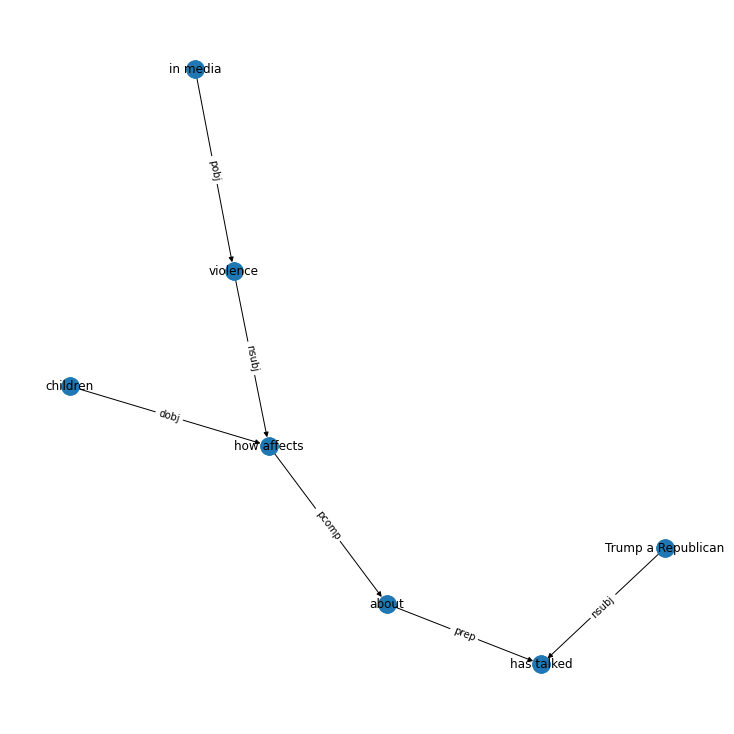

In [17]:
draw_graph.draw_graph(query_graph)

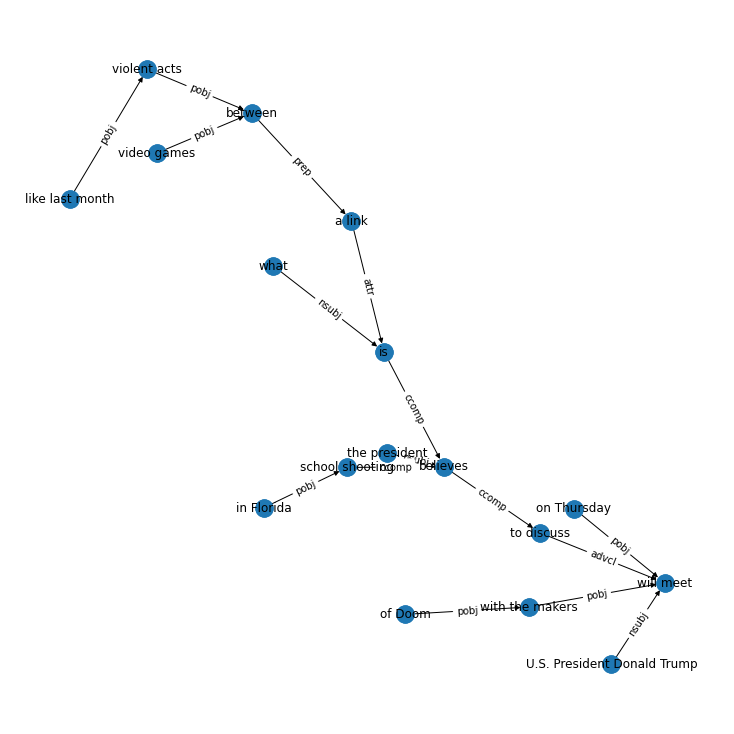

In [18]:
draw_graph.draw_graph(get_graph_from_sent(sim_30_df.sentences[0])[0])

In [ ]:
## visualization
## prepare query samples
## semantic role labeling
## measure the quality of word matching

In [210]:
def cosine_similarity(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot/(norm1*norm2)


def get_wms(doc1, doc2, emb1, emb2):
    # we treat doc1 as the query document
    result1 = [(word, emb) for word, emb in zip(doc1,emb1) if (word not in stop_words) and (not np.all(emb==0))]
    document1 = [x[0] for x in result1]
    embedding1 = [x[1] for x in result1]
    
    result2 = [(word, emb) for word, emb in zip(doc2,emb2) if (word not in stop_words) and (not np.all(emb==0))]
    document2 = [x[0] for x in result2]
    embedding2 = [x[1] for x in result2]
    
    s1 = set(document1)
    s2 = set(document2)
    
    d2 = {}
    for s in s2:
        d2[s] = document2.count(s)/len(document2)
    
    sent_sim = []
    for i2, e2 in enumerate(embedding2):
        word_sim = []
        for e1 in embedding1:
            word_sim.append(cosine_similarity(e1, e2))
#         print(document2[i2], word_sim)
        sent_sim.append(max(word_sim)*d2[document2[i2]])
        print(f'{document2[i2]} matches {document1[np.argmax(word_sim)]}')
    return sum(sent_sim)

In [25]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiajinghu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
query_sentence

'Trump, a Republican, has talked about how violence in media affects children'

In [20]:
query_w2v = get_word2vec_embeddings(query_sentence)

In [191]:
sent = sim_30_df.sentences[9]
print(sent)
print()
get_wms(nltk.word_tokenize(query_sentence), nltk.word_tokenize(sent), query_w2v, get_word2vec_embeddings(sent))

The surge of violence has also raised new questions about U.S. relations with Pakistan, weeks after Trump denounced it for what he said was its failure to crack down on Taliban safe havens on its soil, and ordered big cuts in security aid.



0.23866940908400075

In [50]:
# look at #3,4,7,8
total_match = 21 + 34 + 38 + 19 + 24 + 21 + 34 + 20 + 23 + 22
total_could_be_matched = 8 + 9 + 12 + 4 + 12 + 4 + 13 + 8 + 9 + 5
correct_match = 5 + 3 + 4 + 1 + 1 + 1 + 6 + 1 + 1 + 5 
print('word level match')
print('correct over total match', correct_match/total_match)
print('correct over total meaningful match', correct_match/total_could_be_matched)

word level match
correct over total match 0.109375
correct over total meaningful match 0.3333333333333333


The surge of violence has also raised new questions about U.S. relations with Pakistan, weeks after Trump denounced it for what he said was its failure to crack down on Taliban safe havens on its soil, and ordered big cuts in security aid.

has also raised matches has talked
The surge matches Trump a Republican
of violence matches violence
new questions matches children
about U.S. relations matches how affects
with Pakistan matches Trump a Republican
ordered matches has talked
big cuts matches Trump a Republican
in security aid matches in media
weeks denounced matches has talked
Trump matches Trump a Republican
it matches violence
after matches in media
for matches about
said matches has talked
he matches violence
was matches has talked
what matches children
it failure matches violence
to crack matches has talked
down matches about
on Taliban safe havens matches in media
on it soil matches violence
( has talked , Trump a Republican ) matches  ( has also raised , The surge )
( Trump a R

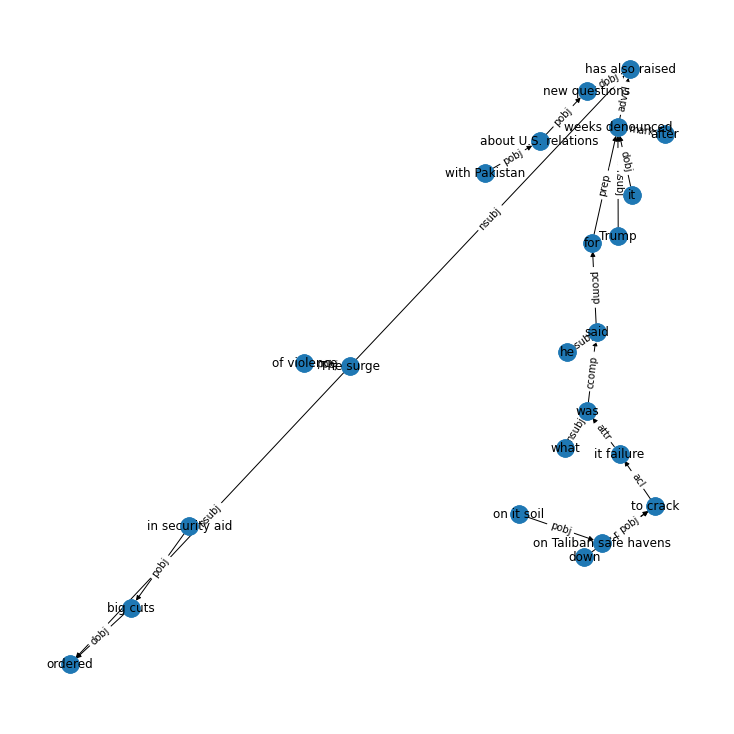

In [144]:
sent = sim_30_df.sentences[9]
print(sent)
print()
query_coref = get_coref_and_dp.get_neural_coreference(query_sentence)
query_w2v = get_word2vec_embeddings(' '.join(query_coref))
sent_traph, sent_w2v = get_graph_from_sent(sent)
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)
draw_graph.draw_graph(get_graph_from_sent(sent)[0])

In [145]:
# look at #
total_match = 17 + 29 + 33 + 24 + 23 + 21 + 10 + 16 + 16 + 23
total_could_be_matched = 6 + 7 + 7 + 3 + 8 + 4 + 3 + 5 + 5 + 5
correct_match = 4 + 3 + 4 + 3 + 5 + 2 + 3 + 4 + 2 + 4
print('node level match')
print('correct over total match', correct_match/total_match)
print('correct over total meaningful match', correct_match/total_could_be_matched)

node level match
correct over total match 0.16037735849056603
correct over total meaningful match 0.6415094339622641


## Query Samples

In [4]:
model = SentenceTransformer('distilroberta-base-msmarco-v1')

In [178]:
# asking for action given a range of sub and obj
q1 = 'How do people expect interest rate to go'
s1 = """"What might be supporting the dollar: expectations of Fed rate hikes have really increased over the last week 
or so," said Daniel Ghali, commodity strategist at TD Securities, after new Chair Jerome Powell's testimony indicated 
his optimistic outlook on the U.S. economy and opened the door for four interest rate hikes.
"""

q2 = 'How do retail companies react to tax increase'
s2 = """
"""
q3 = 'How does increasing interest rate impact banks'
q4 = 'What fraud activities do financial companies commit to'
q5 = 'How does tariffs on Chinese goods impact US economy'

# asking for action for a specific subj
q5 = 'What is Microsoft going to do'

# asking for subj given action
q6 = 'What are the companies that went bankrupt'
q7 = 'What are the companies that got sued'

# asking for obj
q8 = "What drives manufacturer companies' revenue"
q9 = ''


## Compare wmd and graph distance using query 1 sentences

In [4]:
q1_sents = pd.read_csv('../data/financial_news/interim/query_1_sentences.csv')
q1_sents = q1_sents.rename(columns = {'Sentence':'sentences'})
q1_sents.head()

,Title,sentences,whole_sim,subject_sim,action_sim,obj_sim
0,NaN,What might be supporting the dollar: expectati...,5,5,5,5
1,Markets getting increasingly comfortable with ...,He has generally supported the existing outloo...,3,0,0,5
2,Powell taking over as Fed chairman at time of ...,"But while the immediate horizon appears clear,...",0,0,0,1
3,Jump in bond yields signals more Fed rate hike...,"""I think you're going to continue to see highe...",3,0,5,5
4,"Washington is lighting an economic fire, and '...",The bulls are finding comfort in sound fundame...,1,0,0,3


In [179]:
query_dp = get_coref_and_dp.get_spacy_dependency(q1)
query_coref = get_coref_and_dp.get_neural_coreference(q1)
query_w2v = get_word2vec_embeddings(' '.join(query_coref))
query_data = build_semantic_graph.merge_dp_coref([query_dp], [query_coref])
sent = build_tree(query_data[0])
sent = {'sequence':sent['words'], 'tree':prune(sent['tree'], sent['words'])}
sent = {'sequence': sent['sequence'], 'tree': rearrange(sent['tree'], sent['sequence'])}
query_graph = get_graph(sent['tree'])
query_graph, query_w2v = get_graph_from_sent(q1)

In [208]:
q1_sents['wms'] = q1_sents.sentences.apply(lambda x: get_wms(query_coref, get_coref_and_dp.get_neural_coreference(x),
                                                      query_w2v, get_word2vec_embeddings(' '.join(get_coref_and_dp.get_neural_coreference(x)))))

q1_sents['graph_sim_0'] = q1_sents.sentences.apply(lambda x: get_graph_similarity(query_graph, 
                                                                                  get_graph_from_sent(x)[0],
                                                                                  query_w2v,
                                                                                  get_word2vec_embeddings(' '.join(get_coref_and_dp.get_neural_coreference(x))
                                                                                                         )
                                                                                 , threshold=0)[0])
q1_sents['graph_sim_0.9'] = q1_sents.sentences.apply(lambda x: get_graph_similarity(query_graph, 
                                                                                  get_graph_from_sent(x)[0],
                                                                                  query_w2v,
                                                                                  get_word2vec_embeddings(' '.join(get_coref_and_dp.get_neural_coreference(x))
                                                                                                         )
                                                                                 , threshold=0.9)[0])
q1_sents.to_csv('../data/financial_news/interim/query_1_sentences.csv', index=False)
q1_sents

/Users/jiajinghu/projects/pattern-recognition/src/textsimilarity/get_similarity.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node_features.append(embeddings[[node['index']]].mean(axis=0))


,Title,sentences,subject_sim,action_sim,obj_sim,wms,graph_sim_0,graph_sim_0.9
0,NaN,What might be supporting the dollar: expectati...,5.0,5,5.0,0.342431,1.643777,1.511591
1,Markets getting increasingly comfortable with ...,He has generally supported the existing outloo...,5.0,5,2.0,0.327190,1.950754,1.556587
2,Powell taking over as Fed chairman at time of ...,"But while the immediate horizon appears clear,...",5.0,1,1.0,0.336446,1.596899,1.596899
3,Jump in bond yields signals more Fed rate hike...,"""I think you're going to continue to see highe...",5.0,5,0.0,0.378751,1.390834,1.048493
4,"Washington is lighting an economic fire, and '...",The bulls are finding comfort in sound fundame...,5.0,3,1.0,0.293123,1.877743,1.418200
5,Fed could 'rock the boat' with what it says ab...,The Fed also provides new economic and interes...,5.0,1,1.0,0.391098,1.179724,0.933177
6,UPDATE 1-Wall St Weekahead-Markets fret over F...,"Powell appeared to side with the ""hawks"" again...",5.0,5,2.0,0.379147,1.483932,1.483932
7,Wall St Weekahead-Markets fret over Federal Re...,Federal Reserve chair Jerome Powell has said l...,5.0,0,0.0,0.278925,1.271036,1.132449
8,VERBATIM: Fed to move gradually as economy pic...,New Federal Reserve Chairman Jerome Powell tol...,5.0,3,1.0,0.221316,0.893065,0.804874
9,TREASURIES-U.S. bond yields rise further after...,Most U.S. Treasury yields added to their earl...,5.0,3,1.0,0.265173,1.167712,1.047675


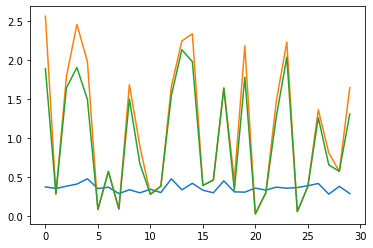

In [204]:
import matplotlib.pyplot as plt
plt.plot(q1_sents[['wms', 'graph_sim_0', 'graph_sim_0.9']])

In [120]:
def get_wms_wn(doc1, doc2, emb1, emb2):
    # we treat doc1 as the query document
    result1 = [(word, emb) for word, emb in zip(doc1,emb1) if (word not in stop_words) and (not np.all(emb==0))]
    document1 = [x[0] for x in result1]
    embedding1 = [x[1] for x in result1]
    
    result2 = [(word, emb) for word, emb in zip(doc2,emb2) if (word not in stop_words) and (not np.all(emb==0))]
    document2 = [x[0] for x in result2]
    embedding2 = [x[1] for x in result2]
    
    
    s1 = set(document1)
    s2 = set(document2)
    
    d2 = {}
    for s in s2:
        d2[s] = document2.count(s)/len(document2)
    
    sent_sim = []
    for i2, w2 in enumerate(document2):
        word_sim = []
#         print('w2:', w2)
        syn2 = wn.synsets(w2)
        if syn2 != []:
            syn2 = syn2[0]
            for i1, w1 in enumerate(document1):
#                 print(w1)
                syn1 = wn.synsets(w1)
                if syn1 != []:
                    syn1 = syn1[0]
                    wup_sim = syn2.wup_similarity(syn1)
                    if wup_sim != None:
                        word_sim.append(wup_sim)
                    else:
                        word_sim.append(0)
                else:
                    word_sim.append(cosine_similarity(embedding1[i1], embedding2[i2]))
        else:
            for e1 in embedding1:
                word_sim.append(cosine_similarity(e1, embedding2[i2]))
                
#             print(wup_sim)
#         print(document2[i2], word_sim)
#         print(word_sim)
        sent_sim.append(max(word_sim)*d2[document2[i2]])
        print(f'{document2[i2]} matches {document1[np.argmax(word_sim)]}')
    return sum(sent_sim)

In [121]:
sent = sim_30_df.sentences[0]
print(sent)
print()
get_wms_wn(nltk.word_tokenize(query_sentence), nltk.word_tokenize(sent),query_w2v, get_word2vec_embeddings(sent))

U.S. President Donald Trump will meet on Thursday with the makers of Doom to discuss what the president believes is a link between video games and violent acts like last month‚ school shooting in Florida.

U.S. matches affects
President matches children
Donald matches Trump
Trump matches Trump
meet matches violence
Thursday matches affects
makers matches children
Doom matches violence
discuss matches violence
president matches children
believes matches violence
link matches Trump
video matches affects
games matches violence
violent matches Trump
acts matches affects
like matches violence
last matches affects
month‚ matches media
school matches affects
shooting matches violence
Florida matches media


0.44360429408764296

In [25]:
wn.synsets('discuss')

[Synset('discus.n.01'),
 Synset('discus.n.02'),
 Synset('discourse.v.01'),
 Synset('hash_out.v.01')]

In [23]:
wn.synsets('talks')[6]

Synset('talk.v.01')

In [26]:
wn.synsets('discuss')[2].wup_similarity(wn.synsets('talks')[6])

0.46153846153846156

In [28]:
wn.synsets('discuss')[0].wup_similarity(wn.synsets('violence')[0])

0.47058823529411764

In [122]:
sent = sim_30_df.sentences[0]
print(sent)
print()
get_wms(nltk.word_tokenize(query_sentence), nltk.word_tokenize(sent),query_w2v, get_word2vec_embeddings(sent))

U.S. President Donald Trump will meet on Thursday with the makers of Doom to discuss what the president believes is a link between video games and violent acts like last month‚ school shooting in Florida.

U.S. matches Republican
President matches Republican
Donald matches Trump
Trump matches Trump
meet matches Trump
Thursday matches Republican
makers matches children
Doom matches Republican
discuss matches talked
president matches Republican
believes matches affects
link matches violence
video matches media
games matches children
violent matches talked
acts matches affects
like matches Republican
last matches Republican
month‚ matches media
school matches media
shooting matches media
Florida matches ,


0.39453819648108707

In [129]:
wn.synsets('video')[0].wup_similarity(wn.synsets('affects')[0])

0.36363636363636365

In [132]:
wn.synsets('affects')[0].hypernyms()

[Synset('feeling.n.01')]

In [133]:
wn.synsets('video')[0].hypernyms()

[Synset('visual_communication.n.01')]

In [134]:
wn.synsets('video')

[Synset('video.n.01'),
 Synset('video_recording.n.01'),
 Synset('video.n.03'),
 Synset('television.n.01')]

In [ ]:
# Sipei - match semantic role labeling. Try use WMD within vector
# Jiajing - enhance the graph

In [212]:
bbcsports = pd.read_csv('../data/bbcsports/raw/test.csv')
bbcsports.head()

,label,sentence
0,rugby,france v wales sat stade de france parissaturd...
1,football,it looks like a good opportunity to try out pl...
2,rugby,and the gloucester prop was only recalled afte...
3,rugby,the two sides both without a win meet on 12 ma...
4,rugby,we have strength and experience up front and w...


In [214]:
rugby = bbcsports[bbcsports.label=='rugby'].sample(5)
rugby

,label,sentence
629,rugby,that is a great way to approach the game and s...
80,rugby,the number eight picked up the ball from the b...
273,rugby,replacements fortey murphy daly vaili cole hay...
238,rugby,a last gasp touchdown from luke narraway pulle...
1480,rugby,andy was sitting two yards from me and i could...


In [230]:
football = bbcsports[bbcsports.label=='football'].sample(5)
football

,label,sentence
1087,football,he s done wrong and we ve all done stupid thin...
119,football,we re learning all the time
2034,football,but this is a player who as well as failing to...
1960,football,beckham defends form for englandengland captai...
1346,football,beckham said it s expected of madrid to get th...


In [236]:
bbcsports.label.unique()

array(['rugby', 'football', 'cricket', 'athletics', 'tennis'],
      dtype=object)

In [237]:
cricket = bbcsports[bbcsports.label=='cricket'].sample(5)
cricket

,label,sentence
1929,cricket,over the last 50 years i have faced many chall...
1231,cricket,so it won t do australia or the game any harm ...
780,cricket,shoaib akhtar s absence in the pakistani side ...
1318,cricket,pakistan opted to leave out pacemen shoaib akh...
1424,cricket,chris cairns 69 and brian lara 52 enjoyed them...


In [246]:
athletics = bbcsports[bbcsports.label=='athletics'].sample(5)
athletics

,label,sentence
1942,athletics,there was yet another russian victory in the w...
48,athletics,france swon the men s 400m with brett rund fou...
2443,athletics,physio sessions with johnston mcevoy in limeri...
731,athletics,campbell who won olympic 4x100m relay gold had...
526,athletics,chepkemei has given a reason for her absence s...


In [252]:
tennis = bbcsports[bbcsports.label=='tennis'].sample(5)
tennis

,label,sentence
218,tennis,i m not using anything to push myself
878,tennis,hewitt said he had had a gutful of trying to p...
834,tennis,what a great way to finish the year said nadal...
380,tennis,it s raining and the umpire doesn t take control
1643,tennis,and although molik stayed in touch sharapova h...


In [253]:
query_sentence = tennis.sentence.iloc[0]
query_graph = get_graph_from_sent(query_sentence)[0]
query_sentence

'i m not using anything to push myself'

and although molik stayed in touch sharapova held on to her serve and then finished off the match with an ace after saving a break point in the 10th game

and matches m not using
stayed matches i
molik matches anything
although matches m not using
in touch sharapova matches i
held matches m not using
then finished matches m not using
off the match matches anything
with an ace matches anything
after matches to push
saving matches m not using
a break point matches anything
in the 10th game matches anything
on matches m not using
to molik serve matches to push
( m not using , anything ) matches  ( saving , a break point )


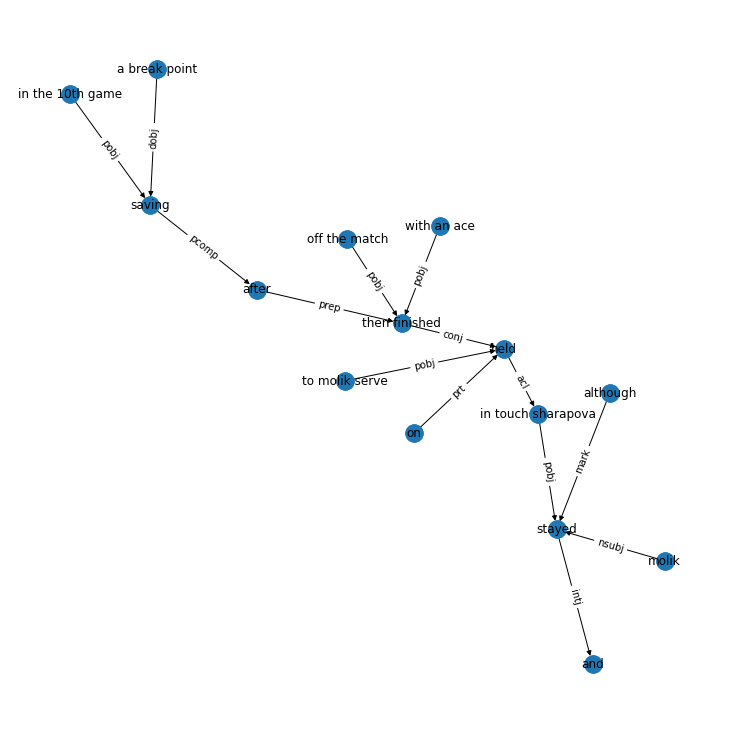

In [257]:
sent = tennis.sentence.iloc[4]
print(sent)
print()
query_coref = get_coref_and_dp.get_neural_coreference(query_sentence)
query_w2v = get_word2vec_embeddings(' '.join(query_coref))
sent_traph, sent_w2v = get_graph_from_sent(sent)
get_graph_similarity(query_graph, sent_traph, query_w2v, sent_w2v, 0)
draw_graph.draw_graph(get_graph_from_sent(sent)[0])

In [258]:
node = 3 + 0 + 0 + 0 + 0 + 1 + 0 + 0 + 0 + 1 + 3 + 0 + 1 + 2 + 1 + 4 + 0 + 0 + 0 + 0
edge = 0 + 0 + 0 + 0 + 0 + 0 + 0 + 0 + 0 + 1 + 0 + 0 + 0 + 0 + 0 + 0 + 1 + 0 + 0 + 0

In [259]:
node/20

0.8

In [260]:
edge/20

0.1